In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
from rdkit import Chem
from dfs_transformer.utils import DFSCode2Graph, Graph2Mol, isValid, Smiles2DFSCode, DFSCode2Smiles, isValidMoleculeDFSCode
from dfs_transformer.utils import load_selfattn_wandb, load_selfattn_local
import os.path
import torch
import torch.nn as nn
import dfs_transformer as dfs
import numpy as np

Using backend: pytorch


In [2]:
pretrained_model = "r2r-nofeat"
if os.path.isdir("../../wandb/artifacts/%s"%pretrained_model):
    bert, cfg = load_selfattn_local("../../wandb/artifacts/%s"%pretrained_model)
else:
    bert, cfg = load_selfattn_wandb(pretrained_model, wandb_dir="../../wandb")

In [3]:
bert.eval()

DFSCodeSeq2SeqFC(
  (encoder): DFSCodeEncoder(
    (emb_dfs): PositionalEncoding(
      (dropout): Dropout(p=0, inplace=False)
    )
    (emb_seq): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (emb_atom): Linear(in_features=118, out_features=120, bias=True)
    (emb_bond): Linear(in_features=5, out_features=120, bias=True)
    (mixer): Linear(in_features=600, out_features=600, bias=True)
    (enc): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=600, out_features=600, bias=True)
          )
          (linear1): Linear(in_features=600, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=600, bias=True)
          (norm1): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((600,), eps=1e-05, e

In [4]:
smiles_list = 1*['CN=C=O'] + 5*['Cc1cn2c(CN(C)C(=O)c3ccc(F)cc3C)c(C)nc2s1'] + 5*['Cc1cc(F)ccc1C(=O)N(C)Cc1c(C)nc2scc(C)n12']

In [5]:
dlist = []
for smiles in smiles_list:
    data = dfs.smiles2graph(smiles)
    data.edge_features = data.edge_attr
    data.node_features = nn.functional.one_hot(data.z-1, num_classes=118).float()
    dlist += [data]

In [27]:
inputs, outputs = dfs.collate_BERT(dlist, mode="rnd2rnd", fraction_missing=0.15)

input : CN=C=O
output: CN=C=O
input : Cc1cn2c(CN(C)C(=O)c3ccc(F)cc3C)c(C)nc2s1
output: Cc1cn2c(CN(C)C(=O)c3ccc(F)cc3C)c(C)nc2s1
input : Cc1cn2c(CN(C)C(=O)c3ccc(F)cc3C)c(C)nc2s1
output: Cc1cc(F)ccc1CN(C)Cc1c(C)nc2sc(C=O)cn12
input : Cc1cn2c(CN(C)C(=O)c3ccc(F)cc3C)c(C)nc2s1
output: Cc1cn2c(CN(C)C(=O)c3ccc(F)cc3C)c(C)nc2s1
input : Cc1cn2c(CN(C)C(=O)c3ccc(F)cc3C)c(C)nc2s1
output: Cc1cn2c(CN(C)C(=O)c3ccc(F)cc3C)c(C)nc2s1
input : Cc1cn2c(CN(C)C(=O)c3ccc(F)cc3C)c(C)nc2s1
output: Cc1cn2c(CN(C)C(=O)Cc3cccc(F)c3)c(C)nc2s1
Explicit valence for atom # 13 N, 6, is greater than permitted
input : Cc1cc(F)ccc1C(=O)N(C)Cc1c(C)nc2scc(C)n12
output: Cc1cc(F)ccc1C(=O)N(C)Cc1c(C)nc2scc(C)n12
input : Cc1cc(F)ccc1C(=O)N(C)Cc1c(C)nc2scc(C)n12
output: Cc1cc(F)ccc1C(=O)NCCc1c(C)nc2scc(C)n12
input : Cc1cc(F)ccc1C(=O)N(C)Cc1c(C)nc2scc(C)n12
output: Cc1ccc(C(=O)NCCc2c(C)nc3scc(C)n23)c(C)c1
input : Cc1cc(F)ccc1C(=O)N(C)Cc1c(C)nc2scc(C)n12
output: Cc1csc2nc(CN(C)C(=O)c3ccc(F)c(F)c3)c(C)n12
0.9090909090909091


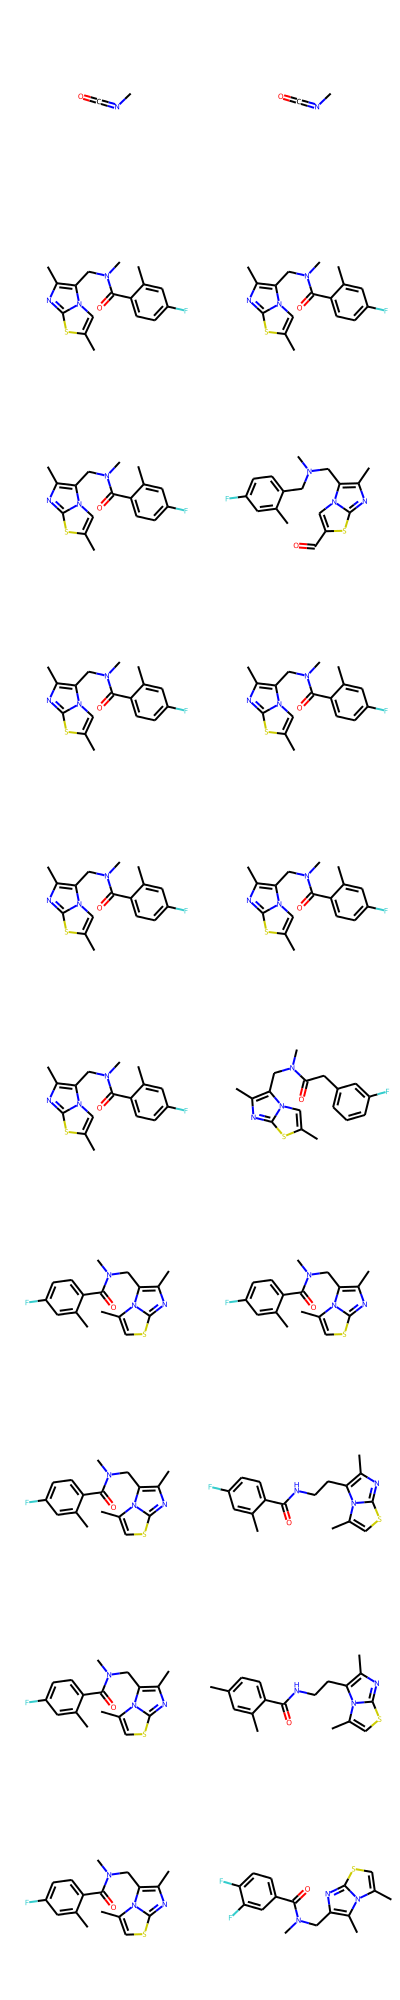

In [35]:
code_list = bert.fwd_code(inputs)
valid_list = []
mols = []
for smiles, code in zip(smiles_list, code_list):
    try:
        valid_list += [isValidMoleculeDFSCode(code)]
        if valid_list[-1]:
            print('input :', smiles)
            print('output:', DFSCode2Smiles(code))
            mols += [Chem.MolFromSmiles(smiles)]
            mols += [Chem.MolFromSmiles(DFSCode2Smiles(code))]
    except:
        valid_list += [False]
valid = np.asarray(valid_list)
print(valid.sum()/len(valid))
Chem.Draw.MolsToGridImage(mols, molsPerRow=2)

In [36]:
code_list = bert.fwd_code_all(inputs)
valid_list = []
mols = []
for smiles, code in zip(smiles_list, code_list):
    try:
        valid_list += [isValidMoleculeDFSCode(code)]
        if valid_list[-1]:
            print('input :', smiles)
            print('output:', DFSCode2Smiles(code))
            mols += [Chem.MolFromSmiles(smiles)]
            mols += [Chem.MolFromSmiles(DFSCode2Smiles(code))]
    except:
        valid_list += [False]
valid = np.asarray(valid_list)
Chem.Draw.MolsToGridImage(mols, molsPerRow=2)

In [37]:
inputs['atm_from'].shape

torch.Size([25, 11, 118])

In [38]:
inputs = {'dfs_from': torch.ones(25, 10, dtype=torch.long)*(-1),
          'dfs_to': torch.ones(25, 10, dtype=torch.long)*(-1),
          'atm_from': torch.ones(25, 10, 118)*(-1),
          'atm_to':torch.ones(25, 10, 118)*(-1),
          'bnd':torch.ones(25, 10, 5)*(-1)}

In [39]:
inputs['dfs_from'][0] = 0
inputs['dfs_to'][0] = 1

In [40]:
bert.fwd_code_all(inputs)

[[[0, 1, 6, 0, 6],
  [1, 2, 6, 0, 6],
  [2, 3, 6, 0, 6],
  [3, 4, 6, 0, 6],
  [4, 5, 6, 0, 6],
  [5, 6, 6, 0, 6],
  [6, 7, 6, 0, 6],
  [6, 7, 6, 0, 6],
  [7, 8, 6, 0, 6],
  [8, 9, 6, 0, 6],
  [9, 10, 6, 0, 6],
  [10, 11, 6, 0, 6],
  [11, 12, 6, 0, 6],
  [12, 13, 6, 0, 6],
  [13, 14, 6, 0, 6],
  [14, 15, 6, 0, 6],
  [15, 15, 6, 0, 6],
  [15, 16, 6, 0, 6],
  [16, 18, 6, 0, 6],
  [17, 18, 6, 0, 6],
  [18, 19, 6, 0, 6],
  [19, 20, 6, 0, 6],
  [20, 21, 6, 0, 6],
  [21, 22, 6, 0, 6],
  [0, 23, 6, 0, 6]],
 [[0, 1, 6, 0, 6],
  [1, 2, 6, 0, 6],
  [2, 3, 6, 0, 6],
  [3, 4, 6, 0, 6],
  [4, 5, 6, 0, 6],
  [5, 6, 6, 0, 6],
  [6, 7, 6, 0, 6],
  [6, 7, 6, 0, 6],
  [7, 8, 6, 0, 6],
  [8, 9, 6, 0, 6],
  [9, 10, 6, 0, 6],
  [10, 11, 6, 0, 6],
  [11, 12, 6, 0, 6],
  [12, 13, 6, 0, 6],
  [13, 14, 6, 0, 6],
  [14, 15, 6, 0, 6],
  [15, 15, 6, 0, 6],
  [15, 16, 6, 0, 6],
  [16, 18, 6, 0, 6],
  [17, 18, 6, 0, 6],
  [18, 19, 6, 0, 6],
  [19, 20, 6, 0, 6],
  [20, 21, 6, 0, 6],
  [21, 22, 6, 0, 6],
  [0, 23, 6, 

In [41]:
inputs

{'dfs_from': tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [-1, -1, -